These functions are here to install any necessary packages for the ML pipeline. Additionally, it mounts the Google drive for the access to the hosted data. Comment it out if it is unnecessary.

None of this was generated using an LLM.

In [ ]:
!python --version
!pip install nilearn

# Mount google drive for data folder
from google.colab import drive
drive.mount('/content/drive')

Python 3.11.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 85.2 MB/s eta 0:00:00
Mounted at /content/drive


These are all the imports for the various sections. They are collected here to provide a singular area to import them and make sure there are no duplicates. Claude Sonnet 3.7 frequently tried to import them multiple times.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import math
import numpy as np
import os
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nibabel as nib
from nilearn import plotting, image
import pandas as pd
from scipy.ndimage import zoom
from pathlib import Path

DATA_DIR = 'drive/MyDrive/Colab Notebooks/ADNI'

This section is to gather the demographics of the patients and visualize how they are distributed. To keep things memory efficient, the MRI data was processed separately. Instead of using a larger file format that could incorporate more patient data, group, patient id, imaged id, age, and sex were used in that order to create the unique file names of the MRIs. So to collect demographic information, one must simply gather all the filenames and parse them.

All of this code is hand written.

In [ ]:
zip_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.zip')]
data_files = []

for zip_file in zip_files:
    with zipfile.ZipFile(f'{DATA_DIR}/{zip_file}', 'r') as zip:
        for file in zip.infolist():
            if file.filename.endswith('.npz'):
                data_files.append(file.filename)

In [ ]:
print(data_files)

['AD-099_S_0372-I49534-81-M.npz', 'AD-020_S_0213-I60608-63-M.npz', 'AD-133_S_1170-I149649-75-M.npz', 'AD-023_S_0084-I31201-75-F.npz', 'AD-126_S_0891-I124151-81-F.npz', 'AD-141_S_0340-I47861-84-F.npz', 'AD-130_S_1337-I80952-71-M.npz', 'AD-033_S_1281-I102011-80-F.npz', 'AD-057_S_1371-I62992-86-M.npz', 'AD-023_S_0916-I31532-80-M.npz', 'AD-033_S_0889-I51624-75-F.npz', 'AD-136_S_0426-I66777-81-M.npz', 'AD-024_S_1307-I77052-75-F.npz', 'AD-027_S_1082-I65364-71-F.npz', 'AD-022_S_0129-I59483-80-F.npz', 'AD-128_S_0216-I101997-85-M.npz', 'AD-033_S_0724-I54730-79-M.npz', 'AD-082_S_1377-I80387-84-M.npz', 'AD-029_S_1184-I67209-65-F.npz', 'AD-126_S_0784-I163717-78-F.npz', 'AD-057_S_1373-I80257-76-M.npz', 'AD-029_S_0999-I64893-71-M.npz', 'AD-127_S_1382-I66309-65-M.npz', 'AD-114_S_0374-I39816-76-F.npz', 'AD-116_S_0487-I89661-78-M.npz', 'AD-128_S_0740-I69059-73-M.npz', 'AD-023_S_0916-I89742-80-M.npz', 'AD-114_S_0228-I49734-80-F.npz', 'AD-057_S_1371-I109121-86-M.npz', 'AD-014_S_0328-I70656-77-M.npz', 'AD

In [ ]:
demographics = []

for file in data_files:
    splits = file.split('-')
    demographics.append({'age': int(splits[3]), 'sex': splits[4].split('.')[0]})

print(demographics)

[{'age': 81, 'sex': 'M'}, {'age': 63, 'sex': 'M'}, {'age': 75, 'sex': 'M'}, {'age': 75, 'sex': 'F'}, {'age': 81, 'sex': 'F'}, {'age': 84, 'sex': 'F'}, {'age': 71, 'sex': 'M'}, {'age': 80, 'sex': 'F'}, {'age': 86, 'sex': 'M'}, {'age': 80, 'sex': 'M'}, {'age': 75, 'sex': 'F'}, {'age': 81, 'sex': 'M'}, {'age': 75, 'sex': 'F'}, {'age': 71, 'sex': 'F'}, {'age': 80, 'sex': 'F'}, {'age': 85, 'sex': 'M'}, {'age': 79, 'sex': 'M'}, {'age': 84, 'sex': 'M'}, {'age': 65, 'sex': 'F'}, {'age': 78, 'sex': 'F'}, {'age': 76, 'sex': 'M'}, {'age': 71, 'sex': 'M'}, {'age': 65, 'sex': 'M'}, {'age': 76, 'sex': 'F'}, {'age': 78, 'sex': 'M'}, {'age': 73, 'sex': 'M'}, {'age': 80, 'sex': 'M'}, {'age': 80, 'sex': 'F'}, {'age': 86, 'sex': 'M'}, {'age': 77, 'sex': 'M'}, {'age': 80, 'sex': 'F'}, {'age': 88, 'sex': 'M'}, {'age': 70, 'sex': 'M'}, {'age': 77, 'sex': 'M'}, {'age': 75, 'sex': 'M'}, {'age': 72, 'sex': 'F'}, {'age': 84, 'sex': 'M'}, {'age': 79, 'sex': 'M'}, {'age': 74, 'sex': 'F'}, {'age': 72, 'sex': 'F'},

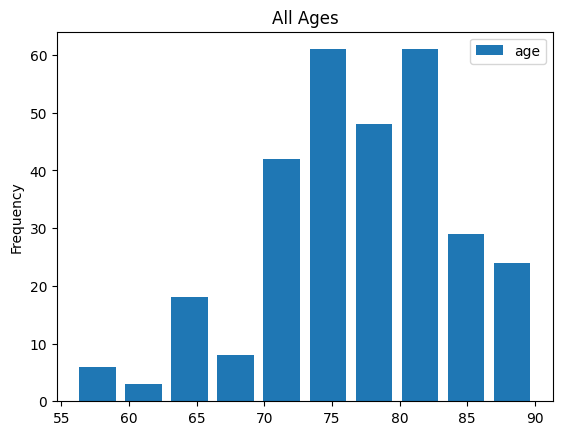

,age
min,56.0
max,90.0
mean,76.8


In [ ]:
df_demos = pd.DataFrame(demographics)
df_demos.plot(kind='hist', grid=False, rwidth=0.8, title='All Ages')
plt.show()

df_demos.agg({'age': ['min', 'max', 'mean']})

<Axes: title={'center': 'Sexes'}, xlabel='sex'>

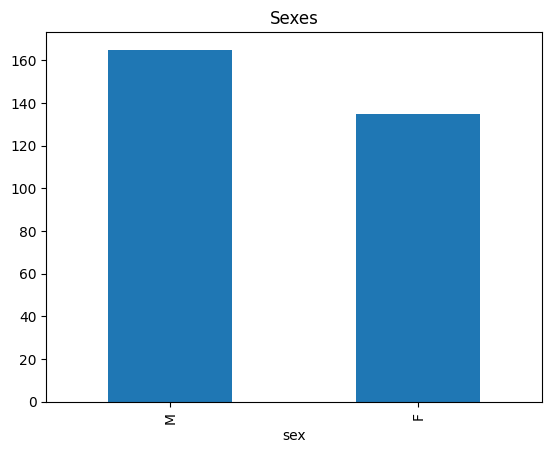

In [ ]:
df_demos['sex'].value_counts().plot(kind='bar', title='Sexes')

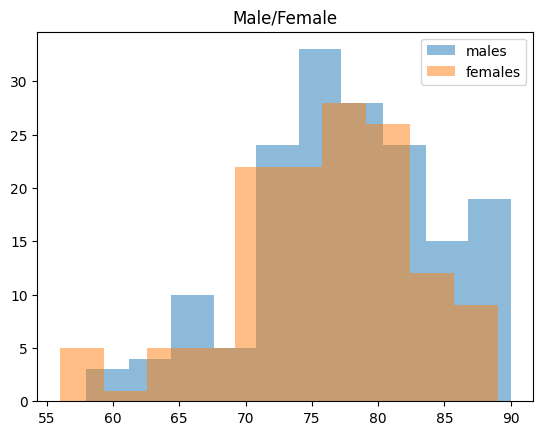

In [ ]:
males = df_demos[df_demos['sex'] == 'M']
females = df_demos[df_demos['sex'] == 'F']

x = males['age']
y = females['age']

plt.hist(x, alpha=0.5, label='males')
plt.hist(y, alpha=0.5, label='females')
plt.legend(loc='upper right')
plt.title('Male/Female')
plt.show()

This section loads the data in by extracting it from the three data groups (AD, CN, MCI). The data is saved as '.npz' file and has been preprocessed to the desired shaped (96x96x96) and normalized to Montreal Neurological Institute (MNI) coordinate space. A Gaussian blur with $0 \leq \sigma \leq 1.5$ was applied to each scan.

All of this was generated with Claude Sonnet 3.7. All package imports were moved to the top to create a cohesive area for them to prevent duplicate imports.

In [ ]:
class AlzheimerDataset(data.Dataset):
    """
    Dataset for loading Alzheimer's disease MRI scans from preprocessed zip files.
    The dataset handles loading scans from multiple zip files, where each file contains
    numpy arrays for brain scans along with metadata including patient group, ID, and age.
    """
    def __init__(self, data_dir=DATA_DIR, transform=None):
        """
        Initialize the dataset.

        Parameters:
        -----------
        data_dir : str
            Directory containing the processed zip files
        transform : callable, optional
            Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []

        # Find all zip files in the directory
        zip_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
                    if f.endswith('.zip')]

        # Load sample information from all zip files
        for zip_path in zip_files:
            self._load_zip_index(zip_path)

        print(f"Loaded {len(self.samples)} samples from {len(zip_files)} zip files")

    def _load_zip_index(self, zip_path):
        """
        Load sample information from a zip file.

        Parameters:
        -----------
        zip_path : str
            Path to the zip file
        """
        try:
            with zipfile.ZipFile(zip_path, 'r') as zipf:
                for filename in zipf.namelist():
                    if filename.endswith('.npz'):
                        # Parse filename to extract metadata
                        # Format: group-patient_id-image_id-age-sex.npz
                        parts = filename.split('.')[0].split('-')

                        # Handle filenames with and without age/sex information
                        if len(parts) >= 3:
                            group = parts[0]
                            patient_id = parts[1]
                            image_id = parts[2]

                            # Extract age if available (default to None)
                            age = None
                            if len(parts) >= 4 and parts[3].replace('.', '', 1).isdigit():
                                age = float(parts[3])

                            # Extract sex if available (default to None)
                            sex = None
                            if len(parts) >= 5:
                                sex = parts[4]

                            # Convert group to class index
                            label = {'CN': 0, 'MCI': 1, 'AD': 2}.get(group, -1)

                            if label != -1:  # Valid group
                                self.samples.append({
                                    'zip_path': zip_path,
                                    'filename': filename,
                                    'group': group,
                                    'label': label,
                                    'patient_id': patient_id,
                                    'image_id': image_id,
                                    'age': age,
                                    'sex': sex
                                })
        except Exception as e:
            print(f"Error loading zip file {zip_path}: {e}")

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Parameters:
        -----------
        idx : int
            Index of the sample

        Returns:
        --------
        dict
            Dictionary containing the sample data and metadata
        """
        sample_info = self.samples[idx]

        # Load the actual data from the zip file
        with zipfile.ZipFile(sample_info['zip_path'], 'r') as zipf:
            with zipf.open(sample_info['filename']) as f:
                buffer = io.BytesIO(f.read())
                data_npz = np.load(buffer)
                scan_data = data_npz['data']

        # Convert to tensor
        scan_tensor = torch.from_numpy(scan_data).float()

        # Add channel dimension if missing
        if scan_tensor.dim() == 3:
            scan_tensor = scan_tensor.unsqueeze(0)

        # Apply transforms if any
        if self.transform:
            scan_tensor = self.transform(scan_tensor)

        # Create result dictionary
        result = {
            'scan': scan_tensor,
            'label': sample_info['label'],
            'group': sample_info['group'],
            'patient_id': sample_info['patient_id'],
            'image_id': sample_info['image_id']
        }

        # Add age if available
        if sample_info['age'] is not None:
            result['age'] = torch.tensor(sample_info['age']).float()

        # Add sex if available
        if sample_info['sex'] is not None:
            # Convert sex to numeric: 0 for male (M), 1 for female (F)
            sex_value = 1 if sample_info['sex'].upper() == 'F' else 0
            result['sex'] = torch.tensor(sex_value).long()

        return result

def create_data_loaders(data_dir=DATA_DIR, batch_size=4, num_workers=4,
                       train_val_test_split=(0.7, 0.15, 0.15), transform=None,
                       shuffle=True, random_seed=42):
    """
    Create data loaders for training, validation, and testing.

    Parameters:
    -----------
    data_dir : str
        Directory containing the processed zip files
    batch_size : int
        Batch size for the data loaders
    num_workers : int
        Number of workers for the data loaders
    train_val_test_split : tuple
        Proportions of training, validation, and test sets
    transform : callable, optional
        Optional transform to be applied on the samples
    shuffle : bool
        Whether to shuffle the datasets
    random_seed : int
        Random seed for reproducibility

    Returns:
    --------
    tuple
        (train_loader, val_loader, test_loader)
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Load the full dataset
    full_dataset = AlzheimerDataset(data_dir=data_dir, transform=transform)

    # Calculate split sizes
    dataset_size = len(full_dataset)
    train_size = int(dataset_size * train_val_test_split[0])
    val_size = int(dataset_size * train_val_test_split[1])
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    indices = list(range(dataset_size))
    if shuffle:
        np.random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Create samplers
    train_sampler = data.SubsetRandomSampler(train_indices)
    val_sampler = data.SubsetRandomSampler(val_indices)
    test_sampler = data.SubsetRandomSampler(test_indices)

    # Create data loaders
    train_loader = data.DataLoader(
        full_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers
    )

    val_loader = data.DataLoader(
        full_dataset, batch_size=batch_size, sampler=val_sampler,
        num_workers=num_workers
    )

    test_loader = data.DataLoader(
        full_dataset, batch_size=batch_size, sampler=test_sampler,
        num_workers=num_workers
    )

    print(f"Created data loaders with {train_size} training, {val_size} validation, "
          f"and {test_size} test samples")

    return train_loader, val_loader, test_loader

The next sections will load the PyTorch packages necessary for the CNN model and build the classes needed for the age encoding and model itself.

All of this was generated with Claude Sonnet 3.7. All package imports were moved to the top to create a cohesive area for them to prevent duplicate imports.

In [ ]:
class AgeEncoding(nn.Module):
    """
    Age encoding class inspired by positional encoding in the transformer model.
    Encodes age values into vectors that can be integrated with CNN features.

    The encoding is defined as:
    AE(age, 2i) = sin(age/10000^(2i/d_model))
    AE(age, 2i+1) = cos(age/10000^(2i/d_model))

    Where:
    - age is the patient's age value (rounded to 0.5 decimal places)
    - i is the dimension index
    - d_model is the size of the encoding
    """
    def __init__(self, d_model=512, age_min=0, age_max=120, age_step=0.5):
        """
        Initialize the age encoding module.

        Parameters:
        -----------
        d_model : int
            Size of the age encoding vector
        age_min : float
            Minimum possible age value
        age_max : float
            Maximum possible age value
        age_step : float
            Step size for discretizing age values
        """
        super(AgeEncoding, self).__init__()

        self.d_model = d_model
        self.age_min = age_min
        self.age_max = age_max
        self.age_step = age_step

        # Create encoder layers to transform age encoding to match visual representation
        self.encoder = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.LayerNorm(512),
            nn.Linear(512, 1024)
        )

        # Pre-compute all possible age encodings
        self.num_ages = int((age_max - age_min) / age_step) + 1
        self.register_buffer('age_encodings', self._create_age_encodings())

    def _create_age_encodings(self):
        """
        Pre-compute all possible age encodings.

        Returns:
        --------
        torch.Tensor
            Tensor of shape (num_ages, d_model) containing all possible age encodings
        """
        # Create all possible age values
        ages = torch.arange(self.age_min, self.age_max + self.age_step, self.age_step)

        # Create position encodings for all ages
        position_encodings = torch.zeros(len(ages), self.d_model)

        # Apply sinusoidal encoding
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))

        for idx, age in enumerate(ages):
            position_encodings[idx, 0::2] = torch.sin(age * div_term)
            position_encodings[idx, 1::2] = torch.cos(age * div_term)

        return position_encodings

    def forward(self, age):
        """
        Encode age values into vectors.

        Parameters:
        -----------
        age : torch.Tensor
            Tensor of age values of shape (batch_size,)

        Returns:
        --------
        torch.Tensor
            Encoded age vectors of shape (batch_size, 1024)
        """
        # Discretize age values to the nearest step
        age_indices = ((age - self.age_min) / self.age_step).round().long()

        # Clamp indices to valid range
        age_indices = torch.clamp(age_indices, 0, self.num_ages - 1)

        # Get corresponding encodings
        encodings = self.age_encodings[age_indices]

        # Transform the encodings to match visual representation
        return self.encoder(encodings)

class AlzheimerCNN(nn.Module):
    """
    3D Convolutional Neural Network for Alzheimer's disease detection.
    Distinguishes between Cognitively Normal (CN), Mild Cognitive Impairment (MCI),
    and Alzheimer's Disease (AD) using structural brain MRI scans.

    Key features of this architecture:
    - Instance normalization instead of batch normalization
    - Small-sized kernels in first layer to avoid early spatial downsampling
    - Wide architecture with large numbers of filters
    - Age information integration
    """
    def __init__(self, widening_factor=8, use_age=True):
        """
        Initialize the CNN model.

        Parameters:
        -----------
        widening_factor : int
            Factor to increase the number of filters in each layer
        use_age : bool
            Whether to incorporate age information
        """
        super(AlzheimerCNN, self).__init__()

        self.widening_factor = widening_factor
        self.use_age = use_age

        # Block 1: Small kernel size (1x1x1) to prevent early spatial downsampling
        self.block1 = nn.Sequential(
            nn.Conv3d(1, 4 * widening_factor, kernel_size=1, stride=1, padding=0, dilation=1),
            nn.InstanceNorm3d(4 * widening_factor),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2)
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv3d(4 * widening_factor, 32 * widening_factor, kernel_size=3, stride=1, padding=0, dilation=2),
            nn.InstanceNorm3d(32 * widening_factor),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2)
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv3d(32 * widening_factor, 64 * widening_factor, kernel_size=5, stride=1, padding=2, dilation=2),
            nn.InstanceNorm3d(64 * widening_factor),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2)
        )

        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv3d(64 * widening_factor, 64 * widening_factor, kernel_size=3, stride=1, padding=1, dilation=2),
            nn.InstanceNorm3d(64 * widening_factor),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=5, stride=2)
        )

        # Age encoding if enabled
        if use_age:
            self.age_encoder = AgeEncoding(d_model=512)

        # Calculate the feature size dynamically
        dummy_input = torch.zeros(1, 1, 96, 96, 96)
        self.feature_size = self._calculate_output_shape(dummy_input)

        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_size, 1024)
        self.fc2 = nn.Linear(1024, 3)  # 3 output classes: CN, MCI, AD

        print(f"Feature size after convolutions: {self.feature_size}")

    def _calculate_output_shape(self, x):
        """
        Calculate the output shape of the convolutional layers.

        Parameters:
        -----------
        x : torch.Tensor
            Dummy input of shape (batch_size, channels, height, width, depth)

        Returns:
        --------
        int
            Total number of features after flattening
        """
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.numel()

    def forward(self, x, age=None):
        """
        Forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input 3D brain scan tensor of shape (batch_size, 1, 96, 96, 96)
        age : torch.Tensor or None
            Age values tensor of shape (batch_size,), required if use_age=True

        Returns:
        --------
        torch.Tensor
            Output logits of shape (batch_size, 3)
        """
        # Ensure input has channel dimension
        if x.dim() == 4:
            x = x.unsqueeze(1)  # Add channel dimension if not present

        # Forward through convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Flatten features
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        # FC1
        x = self.fc1(x)

        # Add age information if enabled
        if self.use_age and age is not None:
            age_encoding = self.age_encoder(age)
            x = x + age_encoding

        # FC2 (Output layer)
        x = self.fc2(x)

        return x

This section creates the ML pipeline.

All of this was generated with Claude Sonnet 3.7. All package imports were moved to the top to create a cohesive area for them to prevent duplicate imports.

In [ ]:
class AlzheimerPipeline:
    """
    Pipeline for training, testing, and visualizing the Alzheimer's CNN model.
    """
    def __init__(self, model, train_loader=None, val_loader=None, test_loader=None,
                 device=None, output_dir="results"):
        """
        Initialize the pipeline.

        Parameters:
        -----------
        model : AlzheimerCNN
            The model to test and visualize
        train_loader : DataLoader
            DataLoader for training data
        val_loader : DataLoader
            DataLoader for validation data
        test_loader : DataLoader
            DataLoader for test data
        device : torch.device
            Device to run the model on (CPU or GPU)
        output_dir : str
            Directory to save results
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        # Set device
        if device is None:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Move model to device
        self.model = self.model.to(self.device)

        # Create output directory
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        # Class names for plots
        self.class_names = ["CN", "MCI", "AD"]

        # Tensorboard writer
        self.writer = SummaryWriter(os.path.join(output_dir, "tensorboard"))

        # Initialize metrics
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'test_acc': None,
            'confusion_matrix': None,
            'classification_report': None,
            'roc_auc': None
        }

    def train(self, num_epochs=50, lr=0.001, weight_decay=1e-4, patience=10):
        """
        Train the model.

        Parameters:
        -----------
        num_epochs : int
            Number of epochs to train
        lr : float
            Learning rate
        weight_decay : float
            L2 regularization strength
        patience : int
            Patience for early stopping

        Returns:
        --------
        dict
            Training metrics
        """
        if self.train_loader is None or self.val_loader is None:
            raise ValueError("Train and validation loaders must be provided for training")

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience//2
		)

        # Early stopping variables
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        # Training loop
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            train_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
            for batch in train_bar:
                # Get the data
                scans = batch['scan'].to(self.device)
                labels = batch['label'].to(self.device)

                # Get age if available
                age = batch.get('age')
                if age is not None:
                    age = age.to(self.device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = self.model(scans, age)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Track metrics
                train_loss += loss.item() * scans.size(0)
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

                # Update progress bar
                train_bar.set_postfix(
                    loss=f"{loss.item():.4f}",
                    acc=f"{100. * train_correct / train_total:.2f}%"
                )

            train_loss = train_loss / train_total
            train_acc = 100. * train_correct / train_total

            # Log training metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)
            self.writer.add_scalar('Loss/train', train_loss, epoch)
            self.writer.add_scalar('Accuracy/train', train_acc, epoch)

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                val_bar = tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
                for batch in val_bar:
                    # Get the data
                    scans = batch['scan'].to(self.device)
                    labels = batch['label'].to(self.device)

                    # Get age if available
                    age = batch.get('age')
                    if age is not None:
                        age = age.to(self.device)

                    # Forward pass
                    outputs = self.model(scans, age)
                    loss = criterion(outputs, labels)

                    # Track metrics
                    val_loss += loss.item() * scans.size(0)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    # Update progress bar
                    val_bar.set_postfix(
                        loss=f"{loss.item():.4f}",
                        acc=f"{100. * val_correct / val_total:.2f}%"
                    )

            val_loss = val_loss / val_total
            val_acc = 100. * val_correct / val_total

            # Log validation metrics
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)
            self.writer.add_scalar('Loss/val', val_loss, epoch)
            self.writer.add_scalar('Accuracy/val', val_acc, epoch)

            # Update learning rate
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0

                # Save the best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': best_val_loss,
                    'val_acc': val_acc
                }, os.path.join(self.output_dir, "best_model.pth"))
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Load the best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

        # Plot training curves
        self.plot_training_curves()

        return self.metrics

    def test(self):
        """
        Test the model on the test set.

        Returns:
        --------
        dict
            Test metrics
        """
        if self.test_loader is None:
            raise ValueError("Test loader must be provided for testing")

        # Set model to evaluation mode
        self.model.eval()

        # Initialize metrics
        criterion = nn.CrossEntropyLoss()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        # Initialize arrays for confusion matrix and ROC curves
        y_true = []
        y_pred = []
        y_score = []

        # Test the model
        with torch.no_grad():
            test_bar = tqdm(self.test_loader, desc="Testing")
            for batch in test_bar:
                # Get the data
                scans = batch['scan'].to(self.device)
                labels = batch['label'].to(self.device)

                # Get age if available
                age = batch.get('age')
                if age is not None:
                    age = age.to(self.device)

                # Forward pass
                outputs = self.model(scans, age)
                loss = criterion(outputs, labels)

                # Track metrics
                test_loss += loss.item() * scans.size(0)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

                # Store predictions for confusion matrix and ROC curves
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_score.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

                # Update progress bar
                test_bar.set_postfix(
                    loss=f"{loss.item():.4f}",
                    acc=f"{100. * test_correct / test_total:.2f}%"
                )

        # Calculate test metrics
        test_loss = test_loss / test_total
        test_acc = 100. * test_correct / test_total

        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_score = np.array(y_score)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        self.metrics['confusion_matrix'] = cm

        # Compute ROC AUC
        roc_auc = {}
        for i, class_name in enumerate(self.class_names):
            # One-vs-rest ROC curve
            fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_score[:, i])
            roc_auc[class_name] = auc(fpr, tpr)

        self.metrics['roc_auc'] = roc_auc

        # Compute classification report
        report = classification_report(
            y_true, y_pred,
            target_names=self.class_names,
            output_dict=True
        )
        self.metrics['classification_report'] = report

        # Log test metrics
        self.metrics['test_loss'] = test_loss
        self.metrics['test_acc'] = test_acc

        # Print test summary
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names))

        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Plot ROC curves
        self.plot_roc_curves(y_true, y_score)

        return self.metrics

    def plot_training_curves(self):
        """
        Plot training and validation loss and accuracy curves.
        """
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Get epochs
        epochs = range(1, len(self.metrics['train_loss']) + 1)

        # Plot loss
        ax1.plot(epochs, self.metrics['train_loss'], 'b-', label='Train')
        ax1.plot(epochs, self.metrics['val_loss'], 'r-', label='Validation')
        ax1.set_title('Loss Curves')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot accuracy
        ax2.plot(epochs, self.metrics['train_acc'], 'b-', label='Train')
        ax2.plot(epochs, self.metrics['val_acc'], 'r-', label='Validation')
        ax2.set_title('Accuracy Curves')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        # Adjust layout
        plt.tight_layout()

        # Save figure
        plt.savefig(os.path.join(self.output_dir, "training_curves.png"), dpi=300)
        plt.close()

    def plot_confusion_matrix(self, cm):
        """
        Plot confusion matrix.

        Parameters:
        -----------
        cm : numpy.ndarray
            Confusion matrix
        """
        # Create figure
        plt.figure(figsize=(8, 6))

        # Plot confusion matrix
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=self.class_names,
            yticklabels=self.class_names
        )

        # Set labels
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')

        # Save figure
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "confusion_matrix.png"), dpi=300)
        plt.close()

    def plot_roc_curves(self, y_true, y_score):
        """
        Plot ROC curves.

        Parameters:
        -----------
        y_true : numpy.ndarray
            True labels
        y_score : numpy.ndarray
            Predicted scores
        """
        # Create figure
        plt.figure(figsize=(8, 6))

        # Plot ROC curves for each class
        colors = ['blue', 'red', 'green']
        for i, (class_name, color) in enumerate(zip(self.class_names, colors)):
            # One-vs-rest ROC curve
            fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_score[:, i])
            auc_score = self.metrics['roc_auc'][class_name]

            plt.plot(
                fpr, tpr, color=color, lw=2,
                label=f'{class_name} (AUC = {auc_score:.3f})'
            )

        # Plot random guessing line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)

        # Set labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc='lower right')

        # Set limits
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])

        # Save figure
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "roc_curves.png"), dpi=300)
        plt.close()

    def visualize_saliency_maps(self, num_samples=5):
        """
        Visualize saliency maps for sample inputs.

        Parameters:
        -----------
        num_samples : int
            Number of samples to visualize

        Returns:
        --------
        dict
            Saliency maps information
        """
        if self.test_loader is None:
            raise ValueError("Test loader must be provided for visualization")

        # Set model to evaluation mode
        self.model.eval()

        # Create directory for saliency maps
        saliency_dir = os.path.join(self.output_dir, "saliency_maps")
        os.makedirs(saliency_dir, exist_ok=True)

        # Get samples from each class
        class_samples = {class_idx: [] for class_idx in range(len(self.class_names))}

        # Collect samples
        with torch.no_grad():
            for batch in self.test_loader:
                # Get the data
                scans = batch['scan']
                labels = batch['label'].numpy()

                # Store samples for each class
                for i, label in enumerate(labels):
                    if len(class_samples[label]) < num_samples:
                        class_samples[label].append({
                            'scan': scans[i].clone(),
                            'label': label,
                            'patient_id': batch['patient_id'][i],
                            'age': batch.get('age')[i].item() if batch.get('age') is not None else None
                        })

                # Check if we have enough samples
                if all(len(samples) >= num_samples for samples in class_samples.values()):
                    break

        # Generate saliency maps for each class
        all_saliency_maps = {}

        for class_idx, samples in class_samples.items():
            class_name = self.class_names[class_idx]
            class_maps = []

            for i, sample in enumerate(samples):
                # Prepare input
                scan = sample['scan'].unsqueeze(0).to(self.device).requires_grad_(True)

                # Prepare age if available
                if sample['age'] is not None:
                    age = torch.tensor([sample['age']]).float().to(self.device)
                else:
                    age = None

                # Forward pass
                self.model.zero_grad()
                output = self.model(scan, age)

                # Get score for true class
                score = output[0][class_idx]

                # Backward pass to compute gradients w.r.t. input
                score.backward()

                # Get gradients
                gradients = scan.grad.abs().detach().cpu().numpy()[0, 0]  # Remove batch and channel dims

                # Normalize gradients for visualization
                gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min() + 1e-8)

                # Get original scan
                original_scan = scan.detach().cpu().numpy()[0, 0]  # Remove batch and channel dims

                # Store maps
                class_maps.append({
                    'patient_id': sample['patient_id'],
                    'original_scan': original_scan,
                    'saliency_map': gradients,
                    'age': sample['age']
                })

                # Visualize middle slices of the brain
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))

                # Get middle slices
                x_mid = original_scan.shape[0] // 2
                y_mid = original_scan.shape[1] // 2
                z_mid = original_scan.shape[2] // 2

                # Plot original scan
                axes[0, 0].imshow(original_scan[x_mid, :, :], cmap='gray')
                axes[0, 0].set_title('Original (Sagittal)')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(original_scan[:, y_mid, :], cmap='gray')
                axes[0, 1].set_title('Original (Coronal)')
                axes[0, 1].axis('off')

                axes[0, 2].imshow(original_scan[:, :, z_mid], cmap='gray')
                axes[0, 2].set_title('Original (Axial)')
                axes[0, 2].axis('off')

                # Plot saliency maps
                axes[1, 0].imshow(gradients[x_mid, :, :], cmap='hot')
                axes[1, 0].set_title('Saliency (Sagittal)')
                axes[1, 0].axis('off')

                axes[1, 1].imshow(gradients[:, y_mid, :], cmap='hot')
                axes[1, 1].set_title('Saliency (Coronal)')
                axes[1, 1].axis('off')

                axes[1, 2].imshow(gradients[:, :, z_mid], cmap='hot')
                axes[1, 2].set_title('Saliency (Axial)')
                axes[1, 2].axis('off')

                # Set title
                age_str = f", Age: {sample['age']}" if sample['age'] is not None else ""
                plt.suptitle(f"Patient: {sample['patient_id']}, Class: {class_name}{age_str}")

                # Save figure
                plt.tight_layout()
                plt.savefig(os.path.join(saliency_dir, f"{class_name}_{sample['patient_id']}.png"), dpi=300)
                plt.close()

            # Store maps for this class
            all_saliency_maps[class_name] = class_maps

        # Create aggregated saliency maps for each class
        for class_idx, class_name in enumerate(self.class_names):
            # Get maps for this class
            maps = [sample['saliency_map'] for sample in all_saliency_maps[class_name]]

            # Average maps
            avg_map = np.mean(maps, axis=0)

            # Normalize
            avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min() + 1e-8)

            # Visualize middle slices
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Get middle slices
            x_mid = avg_map.shape[0] // 2
            y_mid = avg_map.shape[1] // 2
            z_mid = avg_map.shape[2] // 2

            # Plot average saliency maps
            axes[0].imshow(avg_map[x_mid, :, :], cmap='hot')
            axes[0].set_title('Sagittal')
            axes[0].axis('off')

            axes[1].imshow(avg_map[:, y_mid, :], cmap='hot')
            axes[1].set_title('Coronal')
            axes[1].axis('off')

            axes[2].imshow(avg_map[:, :, z_mid], cmap='hot')
            axes[2].set_title('Axial')
            axes[2].axis('off')

            # Set title
            plt.suptitle(f"Average Saliency Map for {class_name}")

            # Save figure
            plt.tight_layout()
            plt.savefig(os.path.join(saliency_dir, f"avg_{class_name}.png"), dpi=300)
            plt.close()

        return all_saliency_maps

    def export_metrics(self):
        """
        Export metrics to CSV files.

        Returns:
        --------
        dict
            Paths to exported metrics
        """
        # Create metrics directory
        metrics_dir = os.path.join(self.output_dir, "metrics")
        os.makedirs(metrics_dir, exist_ok=True)

        # Export training metrics
        if self.metrics['train_loss']:
            train_df = pd.DataFrame({
                'epoch': range(1, len(self.metrics['train_loss']) + 1),
                'train_loss': self.metrics['train_loss'],
                'val_loss': self.metrics['val_loss'],
                'train_acc': self.metrics['train_acc'],
                'val_acc': self.metrics['val_acc']
            })
            train_path = os.path.join(metrics_dir, "training_metrics.csv")
            train_df.to_csv(train_path, index=False)
        else:
            train_path = None

        # Export test metrics
        if self.metrics['test_acc'] is not None:
            # Classification report
            if self.metrics['classification_report']:
                report_df = pd.DataFrame(self.metrics['classification_report']).transpose()
                report_path = os.path.join(metrics_dir, "classification_report.csv")
                report_df.to_csv(report_path)
            else:
                report_path = None

            # Confusion matrix
            if self.metrics['confusion_matrix'] is not None:
                cm_df = pd.DataFrame(
                    self.metrics['confusion_matrix'],
                    index=self.class_names,
                    columns=self.class_names
                )
                cm_path = os.path.join(metrics_dir, "confusion_matrix.csv")
                cm_df.to_csv(cm_path)
            else:
                cm_path = None

            # ROC AUC
            if self.metrics['roc_auc']:
                roc_df = pd.DataFrame({
                    'class': list(self.metrics['roc_auc'].keys()),
                    'auc': list(self.metrics['roc_auc'].values())
                })
                roc_path = os.path.join(metrics_dir, "roc_auc.csv")
                roc_df.to_csv(roc_path, index=False)
            else:
                roc_path = None

            # Test summary
            test_summary = pd.DataFrame({
                'metric': ['test_loss', 'test_acc'],
                'value': [self.metrics['test_loss'], self.metrics['test_acc']]
            })
            test_path = os.path.join(metrics_dir, "test_summary.csv")
            test_summary.to_csv(test_path, index=False)
        else:
            report_path = None
            cm_path = None
            roc_path = None
            test_path = None

        return {
            'training_metrics': train_path,
            'test_summary': test_path,
            'classification_report': report_path,
            'confusion_matrix': cm_path,
            'roc_auc': roc_path
        }

    def predict(self, scan, age=None):
        """
        Make a prediction for a single scan.

        Parameters:
        -----------
        scan : torch.Tensor or numpy.ndarray
            Input scan of shape (1, 96, 96, 96) or (96, 96, 96)
        age : float or None
            Age of the patient

        Returns:
        --------
        dict
            Prediction results
        """
        # Set model to evaluation mode
        self.model.eval()

        # Convert scan to tensor if needed
        if isinstance(scan, np.ndarray):
            scan = torch.from_numpy(scan).float()

        # Add batch and channel dimensions if needed
        if scan.dim() == 3:
            scan = scan.unsqueeze(0).unsqueeze(0)
        elif scan.dim() == 4:
            scan = scan.unsqueeze(0)

        # Move to device
        scan = scan.to(self.device)

        # Prepare age if available
        if age is not None:
            age = torch.tensor([age]).float().to(self.device)

        # Make prediction
        with torch.no_grad():
            outputs = self.model(scan, age)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class = outputs.argmax(1).item()

        # Get prediction details
        prediction = {
            'class_index': predicted_class,
            'class_name': self.class_names[predicted_class],
            'probabilities': {
                class_name: prob.item()
                for class_name, prob in zip(self.class_names, probabilities[0])
            }
        }

        return prediction

    def visualize_prediction(self, scan, age=None, save_path=None):
        """
        Visualize a prediction for a single scan.

        Parameters:
        -----------
        scan : torch.Tensor or numpy.ndarray
            Input scan of shape (1, 96, 96, 96) or (96, 96, 96)
        age : float or None
            Age of the patient
        save_path : str or None
            Path to save the visualization

        Returns:
        --------
        dict
            Prediction results
        """
        # Convert scan to numpy if needed
        if isinstance(scan, torch.Tensor):
            scan_np = scan.detach().cpu().numpy()
            if scan_np.ndim == 4:
                scan_np = scan_np[0]  # Remove channel dimension
        else:
            scan_np = scan

        # Make prediction
        prediction = self.predict(scan, age)

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Get middle slices
        x_mid = scan_np.shape[0] // 2
        y_mid = scan_np.shape[1] // 2
        z_mid = scan_np.shape[2] // 2

        # Plot middle slices
        axes[0].imshow(scan_np[x_mid, :, :], cmap='gray')
        axes[0].set_title('Sagittal')
        axes[0].axis('off')

        axes[1].imshow(scan_np[:, y_mid, :], cmap='gray')
        axes[1].set_title('Coronal')
        axes[1].axis('off')

        axes[2].imshow(scan_np[:, :, z_mid], cmap='gray')
        axes[2].set_title('Axial')
        axes[2].axis('off')

        # Set title
        pred_class = prediction['class_name']
        probabilities = prediction['probabilities']
        prob_str = ', '.join([f"{k}: {v:.2f}" for k, v in probabilities.items()])
        age_str = f", Age: {age}" if age is not None else ""
        plt.suptitle(f"Prediction: {pred_class}{age_str}\nProbabilities: {prob_str}")

        # Save figure
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300)

        plt.tight_layout()
        plt.show()

        return prediction

    def generate_gradcam(self, scan, target_class=None, age=None, save_path=None):
        """
        Generate Grad-CAM visualization for a scan.

        Parameters:
        -----------
        scan : torch.Tensor or numpy.ndarray
            Input scan
        target_class : int or None
            Target class index, if None uses the predicted class
        age : float or None
            Age of the patient
        save_path : str or None
            Path to save the visualization

        Returns:
        --------
        dict
            Grad-CAM results
        """
        # Set model to evaluation mode
        self.model.eval()

        # Convert scan to tensor if needed
        if isinstance(scan, np.ndarray):
            scan = torch.from_numpy(scan).float()

        # Add batch and channel dimensions if needed
        if scan.dim() == 3:
            scan = scan.unsqueeze(0).unsqueeze(0)
        elif scan.dim() == 4:
            scan = scan.unsqueeze(0)

        # Clone the scan and make it require gradients
        scan = scan.clone().to(self.device).requires_grad_(True)

        # Prepare age if available
        if age is not None:
            age = torch.tensor([age]).float().to(self.device)

        # Get activation maps
        activation_maps = []
        gradients = []

        # Forward hooks
        def save_activation(module, input, output):
            activation_maps.append(output.detach().cpu())

        # Backward hooks
        def save_gradient(module, grad_input, grad_output):
            gradients.append(grad_output[0].detach().cpu())

        # Register hooks
        handles = []
        target_layer = self.model.block4[-3]  # Conv3D in the last block
        handles.append(target_layer.register_forward_hook(save_activation))
        handles.append(target_layer.register_full_backward_hook(save_gradient))

        # Forward pass
        outputs = self.model(scan, age)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get predicted class if target_class is not specified
        if target_class is None:
            target_class = outputs.argmax(1).item()

        # Get score for target class
        score = outputs[0][target_class]

        # Backward pass
        self.model.zero_grad()
        score.backward()

        # Remove hooks
        for handle in handles:
            handle.remove()

        # Get activations and gradients
        activations = activation_maps[0][0]  # First batch
        grads = gradients[0][0]  # First batch

        # Weight activations with gradients (Grad-CAM)
        weights = grads.mean(dim=(1, 2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=0)

        # ReLU
        cam = F.relu(cam)

        # Normalize
        cam = cam.detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        # Resize to match input size
        cam_resized = zoom(cam, (scan.shape[2] / cam.shape[0],
                                 scan.shape[3] / cam.shape[1],
                                 scan.shape[4] / cam.shape[2]),
                           order=1)

        # Get scan as numpy array
        scan_np = scan.detach().cpu().numpy()[0, 0]

        # Create figure
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))

        # Get middle slices
        x_mid = scan_np.shape[0] // 2
        y_mid = scan_np.shape[1] // 2
        z_mid = scan_np.shape[2] // 2

        # Plot original images
        axes[0, 0].imshow(scan_np[x_mid, :, :], cmap='gray')
        axes[0, 0].set_title('Original (Sagittal)')
        axes[0, 0].axis('off')

        axes[1, 0].imshow(scan_np[:, y_mid, :], cmap='gray')
        axes[1, 0].set_title('Original (Coronal)')
        axes[1, 0].axis('off')

        axes[2, 0].imshow(scan_np[:, :, z_mid], cmap='gray')
        axes[2, 0].set_title('Original (Axial)')
        axes[2, 0].axis('off')

        # Plot Grad-CAM
        axes[0, 1].imshow(cam_resized[x_mid, :, :], cmap='hot')
        axes[0, 1].set_title('Grad-CAM (Sagittal)')
        axes[0, 1].axis('off')

        axes[1, 1].imshow(cam_resized[:, y_mid, :], cmap='hot')
        axes[1, 1].set_title('Grad-CAM (Coronal)')
        axes[1, 1].axis('off')

        axes[2, 1].imshow(cam_resized[:, :, z_mid], cmap='hot')
        axes[2, 1].set_title('Grad-CAM (Axial)')
        axes[2, 1].axis('off')

        # Plot overlay
        axes[0, 2].imshow(scan_np[x_mid, :, :], cmap='gray')
        axes[0, 2].imshow(cam_resized[x_mid, :, :], cmap='hot', alpha=0.5)
        axes[0, 2].set_title('Overlay (Sagittal)')
        axes[0, 2].axis('off')

        axes[1, 2].imshow(scan_np[:, y_mid, :], cmap='gray')
        axes[1, 2].imshow(cam_resized[:, y_mid, :], cmap='hot', alpha=0.5)
        axes[1, 2].set_title('Overlay (Coronal)')
        axes[1, 2].axis('off')

        axes[2, 2].imshow(scan_np[:, :, z_mid], cmap='gray')
        axes[2, 2].imshow(cam_resized[:, :, z_mid], cmap='hot', alpha=0.5)
        axes[2, 2].set_title('Overlay (Axial)')
        axes[2, 2].axis('off')

        # Set title
        pred_class = self.class_names[target_class]
        prob = probabilities[0][target_class].item()
        age_str = f", Age: {age.item()}" if age is not None else ""
        plt.suptitle(f"Grad-CAM for class: {pred_class} (prob: {prob:.2f}){age_str}")

        # Save figure
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300)

        plt.tight_layout()
        plt.show()

        return {
            'gradcam': cam_resized,
            'class': pred_class,
            'probability': prob
        }

    def run_inference_pipeline(self, loader, num_samples=10, output_dir=None):
        """
        Run inference pipeline on a set of samples.

        Parameters:
        -----------
        loader : DataLoader
            DataLoader to use for inference
        num_samples : int
            Number of samples to process
        output_dir : str or None
            Directory to save results

        Returns:
        --------
        list
            List of prediction results
        """
        if output_dir is None:
            output_dir = os.path.join(self.output_dir, "inference")

        os.makedirs(output_dir, exist_ok=True)

        # Set model to evaluation mode
        self.model.eval()

        # Get samples
        samples = []
        for batch in loader:
            # Get the data
            scans = batch['scan']
            labels = batch['label'].numpy()
            patient_ids = batch['patient_id']

            # Get age if available
            ages = batch.get('age')

            # Add samples
            for i in range(len(scans)):
                samples.append({
                    'scan': scans[i].clone(),
                    'label': labels[i],
                    'label_name': self.class_names[labels[i]],
                    'patient_id': patient_ids[i],
                    'age': ages[i].item() if ages is not None else None
                })

                if len(samples) >= num_samples:
                    break

            if len(samples) >= num_samples:
                break

        # Run inference on samples
        results = []

        for i, sample in enumerate(samples):
            # Visualize prediction
            scan = sample['scan']
            age = sample['age']
            true_label = sample['label_name']
            patient_id = sample['patient_id']

            # Make prediction
            pred_save_path = os.path.join(output_dir, f"pred_{i}_{patient_id}.png")
            prediction = self.visualize_prediction(scan, age, save_path=pred_save_path)

            # Generate Grad-CAM
            gradcam_save_path = os.path.join(output_dir, f"gradcam_{i}_{patient_id}.png")
            gradcam = self.generate_gradcam(scan, target_class=None, age=age, save_path=gradcam_save_path)

            # Store results
            result = {
                'sample_id': i,
                'patient_id': patient_id,
                'true_label': true_label,
                'predicted_label': prediction['class_name'],
                'probabilities': prediction['probabilities'],
                'age': age,
                'correct': true_label == prediction['class_name'],
                'prediction_path': pred_save_path,
                'gradcam_path': gradcam_save_path
            }

            results.append(result)

        # Create summary report
        df = pd.DataFrame(results)
        df.to_csv(os.path.join(output_dir, "inference_summary.csv"), index=False)

        # Create summary plot
        plt.figure(figsize=(10, 6))
        sns.countplot(x='true_label', hue='predicted_label', data=df)
        plt.title('True vs Predicted Labels')
        plt.xlabel('True Label')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "label_distribution.png"), dpi=300)
        plt.close()

        # Calculate accuracy
        accuracy = df['correct'].mean() * 100
        print(f"Inference accuracy: {accuracy:.2f}%")

        return results

    def analyze_age_effects(self, loader, num_age_bins=5, min_samples=10):
        """
        Analyze the effect of age on model predictions.

        Parameters:
        -----------
        loader : DataLoader
            DataLoader to use for analysis
        num_age_bins : int
            Number of age bins to create
        min_samples : int
            Minimum number of samples per age bin

        Returns:
        --------
        dict
            Age analysis results
        """
        # Set model to evaluation mode
        self.model.eval()

        # Create output directory
        output_dir = os.path.join(self.output_dir, "age_analysis")
        os.makedirs(output_dir, exist_ok=True)

        # Collect samples with age information
        samples = []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Collecting samples"):
                # Get the data
                scans = batch['scan']
                labels = batch['label'].numpy()

                # Skip if age not available
                if 'age' not in batch:
                    continue

                ages = batch['age'].numpy()

                # Get predictions
                outputs = self.model(scans.to(self.device), batch['age'].to(self.device))
                _, predictions = outputs.max(1)
                predictions = predictions.cpu().numpy()

                # Add samples
                for i in range(len(scans)):
                    samples.append({
                        'age': ages[i],
                        'true_label': labels[i],
                        'predicted_label': predictions[i],
                        'correct': labels[i] == predictions[i]
                    })

        # Convert to DataFrame
        df = pd.DataFrame(samples)

        # Return if not enough samples with age information
        if len(df) < min_samples:
            print(f"Not enough samples with age information ({len(df)} < {min_samples})")
            return None

        # Create age bins
        df['age_bin'] = pd.cut(df['age'], bins=num_age_bins)

        # Calculate accuracy per age bin
        age_accuracy = df.groupby('age_bin')['correct'].mean() * 100
        age_counts = df.groupby('age_bin').size()

        # Plot accuracy vs age
        plt.figure(figsize=(12, 6))

        ax = age_accuracy.plot(kind='bar', color='skyblue')
        plt.title('Classification Accuracy by Age Group')
        plt.xlabel('Age Group')
        plt.ylabel('Accuracy (%)')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Add counts above bars
        for i, (acc, count) in enumerate(zip(age_accuracy, age_counts)):
            plt.text(i, acc + 1, f"n={count}", ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "accuracy_by_age.png"), dpi=300)
        plt.close()

        # Analyze confusion patterns by age
        age_confusion = {}

        for age_bin in df['age_bin'].unique():
            bin_df = df[df['age_bin'] == age_bin]

            if len(bin_df) < 5:  # Skip bins with too few samples
                continue

            cm = confusion_matrix(
                bin_df['true_label'],
                bin_df['predicted_label'],
                labels=range(len(self.class_names))
            )

            # Normalize by row
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            age_confusion[age_bin] = {
                'confusion_matrix': cm,
                'normalized_confusion_matrix': cm_norm,
                'sample_count': len(bin_df)
            }

            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(
                cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=self.class_names,
                yticklabels=self.class_names
            )
            plt.title(f'Confusion Matrix for Age Group {age_bin} (n={len(bin_df)})')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"cm_age_{age_bin.left:.0f}_{age_bin.right:.0f}.png"), dpi=300)
            plt.close()

        # Save data
        df.to_csv(os.path.join(output_dir, "age_analysis.csv"), index=False)

        return {
            'age_accuracy': age_accuracy,
            'age_counts': age_counts,
            'age_confusion': age_confusion,
            'samples': df
        }

In [ ]:
def create_pipeline(model_path=None, data_dir=DATA_DIR, output_dir='results',
                   batch_size=4, num_workers=4, device=None, widening_factor=8, use_age=True):
    """
    Create a pipeline for testing and visualizing the Alzheimer's CNN model.

    Parameters:
    -----------
    model_path : str or None
        Path to the model checkpoint file
    data_dir : str
        Directory containing the processed data files
    output_dir : str
        Directory to save results
    batch_size : int
        Batch size for the data loaders
    num_workers : int
        Number of workers for the data loaders
    device : torch.device or None
        Device to run the model on (CPU or GPU)
    widening_factor : int
        Widening factor for the model
    use_age : bool
        Whether to use age information

    Returns:
    --------
    AlzheimerPipeline
        Pipeline object
    """
    # Set device
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        data_dir=data_dir,
        batch_size=batch_size,
        num_workers=num_workers
    )

    # Create model
    model = AlzheimerCNN(widening_factor=widening_factor, use_age=use_age)

    # Load model if path provided
    if model_path and os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {model_path} (epoch {checkpoint.get('epoch', 'unknown')})")

    # Create pipeline
    pipeline = AlzheimerPipeline(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        output_dir=output_dir
    )

    return pipeline

In [ ]:
output_dir = 'results'
batch_size = 4
num_workers = 2
widening_factor = 8
use_age = True
num_epochs = 20
learning_rate = 0.001

# Create pipeline
pipeline = create_pipeline(
    data_dir=DATA_DIR,
    output_dir=output_dir,
    batch_size=batch_size,
    num_workers=num_workers,
    widening_factor=widening_factor,
    use_age=use_age
)

# Train the model
pipeline.train(num_epochs=num_epochs, lr=learning_rate, weight_decay=1e-4, patience=10)

# Test the model
pipeline.test()

# Visualize saliency maps
pipeline.visualize_saliency_maps(num_samples=3)

# Run inference pipeline
pipeline.run_inference_pipeline(pipeline.test_loader, num_samples=10)

# Analyze age effects
pipeline.analyze_age_effects(pipeline.test_loader, num_age_bins=5)

# Export metrics
pipeline.export_metrics()

print("Pipeline completed successfully!")

Loaded 900 samples from 3 zip files
Created data loaders with 630 training, 135 validation, and 135 test samples
Feature size after convolutions: 512
Using device: cpu


Epoch 1/20 [Train]:   3%|▎         | 5/158 [05:40<2:48:52, 66.23s/it, acc=40.00%, loss=1.5785]